In [1]:
# How to install OpenPTV-Python

# if you need to install openptv-python, it's recommended to use conda
# Create conda environment with openptv-python
# conda create -n openptv_lineofsight python=3.10
# conda activate openptv_lineofsight
# If you run it on the Codespaces, the python is already encapsulated, simply use pip:
# %pip install git+https://github.com/openptv/openptv-python.git
# %pip install jupyter matplotlib numpy numba

In [2]:
# How to install MyPTV:
# %%bash
# git clone --depth 1 --branch extended_zolof_calibration --single-branch https://github.com/ronshnapp/MyPTV.git
# cd MyPTV
# pip install -e .
# cd ..

In [3]:
# !pip install ipympl

In [4]:
from openptv_python.calibration import Calibration
from openptv_python.parameters import ControlPar, VolumePar
from openptv_python.trafo import pixel_to_metric, dist_to_flat, metric_to_pixel
from openptv_python.multimed import ray_tracing, move_along_ray
from openptv_python.imgcoord import img_coord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [5]:
# openptv way to get the line in 3D from the point in the image space and 
# the calibration parameters


def epipolar_curve_in_3D(
    image_point: np.ndarray,
    origin_cam: Calibration,
    num_points: int,
    cparam: ControlPar,
    vparam: VolumePar,
) -> np.ndarray:
    """
    Get the points lying on the epipolar line from one camera to the other, on.

    the edges of the observed volume. Gives pixel coordinates.

    Assumes the same volume applies to all cameras.

    Arguments:
    ---------
    image_point - the 2D point on the image
        plane of the camera seeing the point. Distorted pixel coordinates.
    Calibration origin_cam - current position and other parameters of the
        camera seeing the point.
    int num_points - the number of points to generate along the line. Minimum
        is 2 for both endpoints.
    ControlParams cparam - an object holding general control parameters.
    VolumeParams vparam - an object holding observed volume size parameters.

    Returns
    -------
    line_points - (num_points,2) array with projection camera image coordinates
        of points lying on the ray stretching from the minimal Z coordinate of
        the observed volume to the maximal Z thereof, and connecting the camera
        with the image point on the origin camera.
    """

    line_points = np.empty((num_points, 3))

    # Move from distorted pixel coordinates to straight metric coordinates.
    x, y = pixel_to_metric(image_point[0], image_point[1], cparam)
    x, y = dist_to_flat(x, y, origin_cam, 0.00001)

    vertex, direct = ray_tracing(x, y, origin_cam, cparam.mm)

    for pt_ix, Z in enumerate(
        np.linspace(vparam.z_min_lay[0], vparam.z_max_lay[0], num_points)
    ):
        # x = line_points[pt_ix], 0)
        # y = <double *>np.PyArray_GETPTR2(line_points, pt_ix, 1)

        line_points[pt_ix, :] = move_along_ray(Z, vertex, direct)
        
        # x, y = img_coord(pos, project_cam, cparam.mm)
        # line_points[pt_ix, 0], line_points[pt_ix, 1] = metric_to_pixel(x, y, cparam)

    return line_points

In [6]:
# Read the required stuff from the working folder
import pathlib, os
working_path = pathlib.Path('OpenPTV_LineOfSight')

In [7]:
camera_1_calibration = Calibration().from_file(os.path.join(working_path,"calibration","cam1.tif.ori"), None)
control_parameters = ControlPar().from_file(os.path.join(working_path,"parameters","ptv.par"))
volume_parameters = VolumePar().from_file(os.path.join(working_path,"parameters","criteria.par"))

No addpar file found. Using default values for radial distortion


In [8]:
curve_3D = epipolar_curve_in_3D(
    image_point=[control_parameters.imx/2, control_parameters.imy/2],
    origin_cam = camera_1_calibration,
    num_points = 10,
    cparam = control_parameters,
    vparam = volume_parameters,
)

In [9]:
cam_position = camera_1_calibration.get_pos()

In [11]:
camera_2_calibration = Calibration().from_file(os.path.join(working_path,"calibration","cam2.tif.ori"), None)

No addpar file found. Using default values for radial distortion


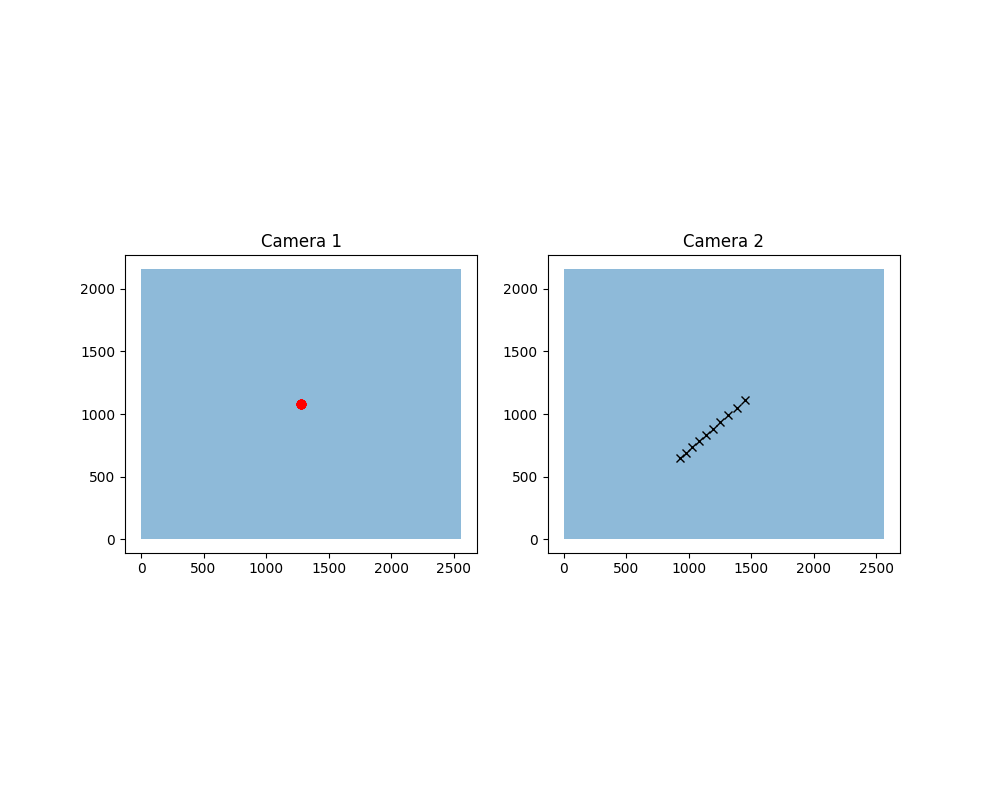

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,8))
from matplotlib.patches import Rectangle

ax[0].add_patch(Rectangle((0,0),control_parameters.imx, control_parameters.imy,alpha = 0.5))
ax[1].add_patch(Rectangle((0,0),control_parameters.imx, control_parameters.imy,alpha = 0.5))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

for point in curve_3D:    
    x, y = img_coord(point, camera_1_calibration, control_parameters.mm)    
    x, y = metric_to_pixel(x, y, control_parameters)
    # print(x,y)
    
    ax[0].plot(x,y,'ro')
    
    
    x, y = img_coord(point, camera_2_calibration, control_parameters.mm)    
    x, y = metric_to_pixel(x, y, control_parameters)
    # print(x,y)
    ax[1].plot(x,y,'kx')    

ax[0].set_title('Camera 1')
ax[1].set_title('Camera 2')
plt.show()
    

In [13]:
# Now we try to create the line of sight using myptv 
from myptv.imaging_mod import camera_wrapper, img_system

# ThreeDModel = 'ExtendedZolof'     # <-- set either to 'Tsai' or to 'ExtendedZolof'
# ThreeDModel = 'Tsai'     # <-- set either to 'Tsai' or to 'ExtendedZolof'
cam_name = 'cam0'        # <-- set to one of: cam0, cam1, cam2, cam3
# directory = '../MyPTV_LineOfSight/cam_Tsai'
directory = 'MyPTV_LineOfSight/cam_extendedZolof'
cam = camera_wrapper(cam_name, directory)
cam.load()

print(cam)

Camera Wrapper instance; camera loaded:

Extended Zolof model camera instace. cam0
 O: [ 313.19555176  -15.23066063 1114.83246883]


In [14]:
class LineOfSight(object):
    
    def __init__(self, cam):
        
        self.cam = cam
        
    
    def get_line(self, x, y):
        P, v = self.cam.get_epipolarline(x, y)
        return P, v
    
    
    def plot_line(self, x, y):
        P, v = self.get_line(x, y)
        
        
        axis = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
        axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
        axis.set_xlim(-50,350), axis.set_ylim(-50,350), axis.set_zlim(0,1200)

        axis.set_box_aspect([axis.get_xlim()[1] - axis.get_xlim()[0],
                             axis.get_ylim()[1] - axis.get_ylim()[0],
                             axis.get_zlim()[1] - axis.get_zlim()[0]])

        axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
        axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
        axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
        axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')


        plt.plot(P[0],P[1],P[2],'o',c='green')
        
        curve_3D = np.array([P+10*v])
        for a_ in np.linspace(0, -P[2]/v[2], num=10):
            curve_3D = np.concatenate((curve_3D, np.array([P + a_*v])))
        
        plt.plot(curve_3D[:,0],curve_3D[:,1],curve_3D[:,2],'-',c='red')
        
        
        
        

LOS = LineOfSight(cam)

In [15]:
LOS.get_line(control_parameters.imx/2, control_parameters.imy/2)


(array([ 313.19555176,  -15.23066063, 1114.83246883]),
 array([-0.14768201,  0.13044815, -0.98037877]))

In [16]:
cam_position = camera_1_calibration.get_pos()
curve_3D = epipolar_curve_in_3D(
    image_point=[control_parameters.imx/2, control_parameters.imy/2],
    origin_cam = camera_1_calibration,
    num_points = 10,
    cparam = control_parameters,
    vparam = volume_parameters,
)

In [17]:
# proPTV copy of LineOfSight
import sys, os
sys.path.append('proPTV_LineOfSight')
from func import *

# static parameter
calibration_path = "proPTV_LineOfSight/calibration/c{cam}/soloff_c{cam}{xy}.txt"
Vmin, Vmax = [0,0,0], [300,300,300]

# user defined parameter
c = 0 # camera ID
xy = np.array([[control_parameters.imx/2,control_parameters.imy/2],[0,0],[2100,0]]) # image coordinates

# plot parameter
mu = 5 # line of sight:  LOF = P0 + mu*P1 , P0 - position vector , P1 - shift vector , mu - shift scalar

# load calibration of camera c
ax, ay = np.loadtxt(calibration_path.format(cam=c,xy="x"),delimiter=','), np.loadtxt(calibration_path.format(cam=c,xy="y"),delimiter=',')
# calculate line of sight
LOF = [proPTV_LineOfSight(p,c,Vmin,Vmax,ax,ay) for p in xy]
# calculate cam position
cam_position_proPTV = Get_Closest_Point(LOF)
print('estimated cam position: ' , cam_position)

# # plot line of sight
# axis = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
# axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
# axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
# axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
# axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
# axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')
# for lof in LOF:
#     plt.plot( [lof[0,0],lof[0,0]+mu*lof[1,0]] , [lof[0,1],lof[0,1]+mu*lof[1,1]] , [lof[0,2],lof[0,2]+mu*lof[1,2]] ,'-',c='red')
# plt.plot(cam_position_proPTV[0],cam_position_proPTV[1],cam_position_proPTV[2],'o',c='green')
# plt.tight_layout(), plt.show()    

estimated cam position:  [ 351.70698953  -20.06356326 1144.55602304]


In [18]:
print(cam_position_proPTV)
print(f'proPTV: {[cam_position_proPTV[0],cam_position_proPTV[2],-cam_position_proPTV[1]]}')
print(f'openPTV: {camera_1_calibration.get_pos()}')
print(f'myPTV: {cam}')



[ 332.45875489   -8.3751952  1392.69019014]
proPTV: [332.4587548914069, 1392.6901901428805, 8.375195201737705]
openPTV: [ 351.70698953  -20.06356326 1144.55602304]
myPTV: Camera Wrapper instance; camera loaded:

Extended Zolof model camera instace. cam0
 O: [ 313.19555176  -15.23066063 1114.83246883]


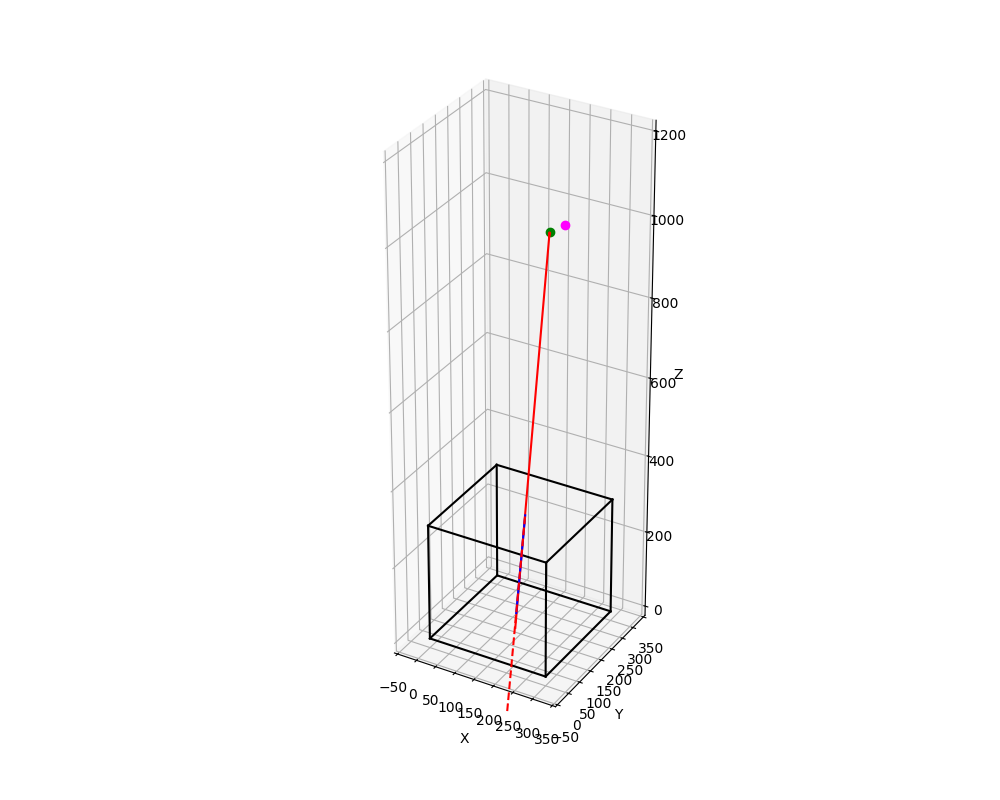

In [19]:

# 1. MyPTV:
LOS.plot_line(control_parameters.imx/2, control_parameters.imy/2)

# 2. openptv-python
plt.plot(cam_position[0],cam_position[1],cam_position[2],'o',c='magenta')
plt.plot(curve_3D[:,0],curve_3D[:,1],curve_3D[:,2],'-',c='blue')

# 3. proPTV
plt.plot(cam_position_proPTV[0],cam_position_proPTV[2],-cam_position_proPTV[1],'x',c='black')

# mu is not clear to me. the angles I think i fixed. 

# for lof in LOF[:1]: # only first point
#     plt.plot( [lof[0,0],lof[0,0]+mu*lof[1,0]] , 1*np.array([lof[0,2],lof[0,2]+mu*lof[1,2]]), -1*np.array([lof[0,1],lof[0,1]+mu*lof[1,1]]) ,'-',c='magenta')

# copied from LineOfSight.main()
for lof in LOF[:1]:
    plt.plot( [lof[0,0],lof[0,0]+mu*lof[1,0]] , [lof[0,1],lof[0,1]+mu*lof[1,1]] , [lof[0,2],lof[0,2]+mu*lof[1,2]] ,'--',c='red')

